<a href="https://colab.research.google.com/github/btcnhung1299/tf-practice/blob/master/TXT_SarcarsmDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf

## Data Gathering

In [2]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json

--2020-09-27 07:22:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2020-09-27 07:22:03 (47.3 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [3]:
df = pd.read_json("./sarcasm.json")
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


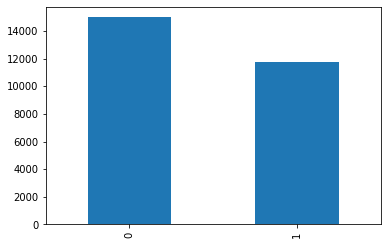

In [4]:
df["is_sarcastic"].value_counts().plot(kind="bar");

In [5]:
texts = df["headline"].values
labels = df["is_sarcastic"].values

## Data Preparation

### Tokenization

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
VOCAB_SIZE = 10000
tokenizer = Tokenizer(VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

### Create samples

In [8]:
df["headline"].apply(lambda x : len(x)).describe()

count    26709.000000
mean        60.910629
std         19.184423
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: headline, dtype: float64

In [9]:
MAX_SEQ_LEN = 128
BUFFER_SIZE = 1024

text_ids = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQ_LEN, padding="post")
samples = tf.data.Dataset.from_tensor_slices((text_ids, labels)).shuffle(BUFFER_SIZE)

### Create dataset

In [10]:
BATCH_SIZE = 64

test_size = 0.2
num_samples = sum(1 for x in samples)
num_train_samples = int(test_size * num_samples)
ds_train = samples.take(num_train_samples).batch(BATCH_SIZE)
ds_val = samples.skip(num_train_samples).batch(BATCH_SIZE)

## Model Architecture

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, GlobalAveragePooling1D, Dense, GlobalMaxPooling1D

In [12]:
EMBED_DIM = 32

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [14]:
history = model.fit(ds_train, epochs=100, validation_data=ds_val)

Epoch 1/100
84/84 [==============================] - 1s 14ms/step - loss: 0.6870 - acc: 0.5587 - val_loss: 0.6839 - val_acc: 0.5618
Epoch 2/100
84/84 [==============================] - 1s 14ms/step - loss: 0.6830 - acc: 0.5611 - val_loss: 0.6819 - val_acc: 0.5615
Epoch 3/100
84/84 [==============================] - 1s 14ms/step - loss: 0.6806 - acc: 0.5615 - val_loss: 0.6796 - val_acc: 0.5608
Epoch 4/100
84/84 [==============================] - 1s 13ms/step - loss: 0.6777 - acc: 0.5602 - val_loss: 0.6764 - val_acc: 0.5612
Epoch 5/100
84/84 [==============================] - 1s 13ms/step - loss: 0.6735 - acc: 0.5604 - val_loss: 0.6726 - val_acc: 0.5613
Epoch 6/100
84/84 [==============================] - 1s 12ms/step - loss: 0.6687 - acc: 0.5626 - val_loss: 0.6684 - val_acc: 0.5602
Epoch 7/100
84/84 [==============================] - 1s 13ms/step - loss: 0.6632 - acc: 0.5630 - val_loss: 0.6629 - val_acc: 0.5618
Epoch 8/100
84/84 [==============================] - 1s 12ms/step - loss: 0.

In [15]:
model.evaluate(ds_val)

334/334 [==============================] - 1s 2ms/step - loss: 0.3920 - acc: 0.8337


[0.3919735252857208, 0.8336765170097351]

### Transfer learning w. pretrained embedding

In [16]:
BATCH_SIZE = 64
BUFFER_SIZE = 1024

samples = tf.data.Dataset.from_tensor_slices((texts, labels)).shuffle(BUFFER_SIZE)
num_samples = sum(1 for x in samples)
test_size = 0.2
num_train_samples = int(test_size * num_samples)

ds_train = samples.take(num_train_samples).batch(BATCH_SIZE)
ds_val = samples.skip(num_train_samples).batch(BATCH_SIZE)

In [24]:
import tensorflow_hub as hub
embedding_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

model = Sequential()
model.add(hub.KerasLayer(embedding_url, input_shape=(), dtype=tf.string, trainable=True))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 147,355,393
Trainable params: 147,355,393
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
model.fit(ds_train, epochs=5, validation_data=ds_val);

Epoch 1/5


84/84 [==============================] - 40s 473ms/step - loss: 0.4522 - acc: 0.8049 - val_loss: 0.3536 - val_acc: 0.8588
Epoch 2/5
84/84 [==============================] - 35s 422ms/step - loss: 0.2451 - acc: 0.9172 - val_loss: 0.4485 - val_acc: 0.8232
Epoch 3/5
84/84 [==============================] - 35s 422ms/step - loss: 0.1391 - acc: 0.9596 - val_loss: 0.3345 - val_acc: 0.8759
Epoch 4/5
84/84 [==============================] - 35s 412ms/step - loss: 0.0969 - acc: 0.9742 - val_loss: 0.3735 - val_acc: 0.8612
Epoch 5/5
84/84 [==============================] - 36s 433ms/step - loss: 0.0722 - acc: 0.9822 - val_loss: 0.3937 - val_acc: 0.8716


In [26]:
model.evaluate(ds_val)

334/334 [==============================] - 14s 42ms/step - loss: 0.3951 - acc: 0.8712


[0.3950897753238678, 0.8712092638015747]